# DECam image querying

This is currently just a test to see if image querying + fits file displaying works

Primarily from the [NOIRLab API examples](https://github.com/NOAO/nat-nb/blob/master/sia.ipynb)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits as fits
from astropy.wcs import WCS

## Locally downloaded fits files

This is just to see what these files look like - the file sizes are quite large so don't download them yourselves unless you need to

In [4]:
# test_image = fits.open("/mnt/c/Users/creat/Downloads/c4d_150609_100758_osj_g_v1.fits.fz")
# test_image = fits.open("/mnt/c/Users/creat/Downloads/c4d_180516_052333_opi_g_v1.fits.fz")

# test_image.info()

# imagenum = 3

# wcs = WCS(test_image[imagenum].header)
# zimage = test_image[imagenum].data

# fig = plt.figure(figsize=(8,16))
# ax = plt.subplot(111, projection=wcs)
# lon = ax.coords['ra']
# lat = ax.coords['dec']
# plt.imshow(zimage,vmin=90,vmax=200)
# zimage.shape

## Querying the live Astro datalab
slightly different than the archive! [example jupyter notebook](https://github.com/astro-datalab/notebooks-latest/blob/aa7e2954d538632a5f0a26665c91906ca2c9cfbc/04_HowTos/SiaService/How_to_use_the_Simple_Image_Access_service.ipynb)

In [23]:
from pyvo.dal import sia
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/ls_dr9"
svc_ls_dr9 = sia.SIAService(DEF_ACCESS_URL)

In [24]:
ra = 335.0 # in degrees
dec = 0.0 # in degrees
fov = 0.2 # in degrees

imgTable = svc_ls_dr9.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()

In [25]:
imgTable

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
ls_dr9,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3348p000-blobmodel-g.fits.fz&extn=1&POS=335.0,0.0&SIZE=0.2,0.2",image/fits,50639,,,3,0,0,0,[],,,[0.26193],,ls_dr9,,DECaLS DR9,archival,,,DECam,g,,,ivo://datalab.noirlab/vo#ivoa_ls_dr9.siav1:ivo://datalab.noao/ls_dr9/legacysurvey-3348p000-blobmodel-g.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3348p000-blobmodel-g.fits.fz&extn=1&POS=335.0,0.0&SIZE=0.2,0.2&preview=true",,,334.875,7.99361e-15,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,,0,DECaLS DR9,22.5,blobmodel,0,0,,0,,Stack,2013-09-05T01:51:44.997,,0
ls_dr9,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3348p000-chi2-z.fits.fz&extn=1&POS=335.0,0.0&SIZE=0.2,0.2",image/fits,12375,,,3,0,0,2,[3600 3600],,,[0.26193],,ls_dr9,,DECaLS DR9,archival,,,DECam,z DECam SDSS c0004 9260.0 1520.0,,,ivo://datalab.noirlab/vo#ivoa_ls_dr9.siav1:ivo://datalab.noao/ls_dr9/legacysurvey-3348p000-chi2-z.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3348p000-chi2-z.fits.fz&extn=1&POS=335.0,0.0&SIZE=0.2,0.2&preview=true",,,334.875,7.99361e-15,--,,,--,0.0,0.0,--,--,--,--,--,--,,,,,0,DECaLS DR9,0,chi2,0,0,,0,,Stack,,,0
ls_dr9,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3348p000-depth-g.fits.fz&extn=1&POS=335.0,0.0&SIZE=0.2,0.2",image/fits,669,,,3,0,0,2,[3600 3600],,,[0.26193],,ls_dr9,,DECaLS DR9,archival,,,DECam,g DECam SDSS c0001 4720.0 1520.0,,,ivo://datalab.noirlab/vo#ivoa_ls_dr9.siav1:ivo://datalab.noao/ls_dr9/legacysurvey-3348p000-depth-g.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3348p000-depth-g.fits.fz&extn=1&POS=335.0,0.0&SIZE=0.2,0.2&preview=true",,,334.875,7.99361e-15,--,,,--,0.0,0.0,--,--,--,--,--,--,,,,,0,DECaLS DR9,0,psfdepth,0,0,,0,,Stack,,,0
ls_dr9,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3348p000-depth-r.fits.fz&extn=1&POS=335.0,0.0&SIZE=0.2,0.2",image/fits,762,,,3,0,0,2,[3600 3600],,,[0.26193],,ls_dr9,,DECaLS DR9,archival,,,DECam,r DECam SDSS c0002 6415.0 1480.0,,,ivo://datalab.noirlab/vo#ivoa_ls_dr9.siav1:ivo://datalab.noao/ls_dr9/legacysurvey-3348p000-depth-r.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3348p000-depth-r.fits.fz&extn=1&POS=335.0,0.0&SIZE=0.2,0.2&preview=true",,,334.875,7.99361e-15,--,,,--,0.0,0.0,--,--,--,--,--,--,,,,,0,DECaLS DR9,0,psfdepth,0,0,,0,,Stack,,,0
ls_dr9,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3348p000-depth-z.fits.fz&extn=1&POS=335.0,0.0&SIZE=0.2,0.2",image/fits,348,,,3,0,0,2,[3600 3600],,,[0.26193],,ls_dr9,,DECaLS DR9,archival,,,DECam,zd DECam k1038,,,ivo://datalab.noirlab/vo#ivoa_ls_dr9.siav1:ivo://datalab.noao/ls_dr9/legacysurvey-3348p000-depth-z.fits.fz

In [14]:
row = imgTable[0]

url = row['access_url']
single_image = fits.open(url)
single_image.info()

Filename: /home/cworley/.astropy/cache/download/url/ffeb50860fc3beaee3e86f909c188ca3/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      83   (1370, 1370)   float32   


In [17]:
# wcs = WCS(single_image.header)
zimage = single_image.data

fig = plt.figure(figsize=(8,16))
ax = plt.subplot(111, projection=wcs)
lon = ax.coords['ra']
lat = ax.coords['dec']
plt.imshow(zimage,vmin=90,vmax=200)
zimage.shape

AttributeError: 'HDUList' object has no attribute 'data'

## Querying the NOIRLab Archive

There are a few steps to querying the database:
-  building up the query based on the region of interest and the desired properties for the images that you want (image type, telescope that took the image, etc)
-  sending the query to the NOIRLab server, which returns a dataframe of information about what files meet the conditions of your query
-  further analyzing the returned dataframe to pick out what images you want
-  accessing / retrieving the images from the url column of the rows (files) in the dataframe that you're interested in

In [4]:
import json
import requests
import pandas as pd

/Users/vernica/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
baseurl = "https://astroarchive.noirlab.edu/api"

url = f'{baseurl}/sia/vohdu?FORMAT=METADATA&format=json'
print(f'URL of service = {url}')
pd.DataFrame(requests.get(url).json()[1:])

URL of service = https://astroarchive.noirlab.edu/api/sia/vohdu?FORMAT=METADATA&format=json


,ParameterName,DataType,DefaultValue,Doc
0,INPUT:FILENAME,char,NA,NA
1,INPUT:FORMAT,char,text/html,Type of content
2,INPUT:telescope,char,ALL,Telescope used to collect raw image. one-of:['...
3,INPUT:instrument,char,ALL,Instrument used to collect raw image. one-of:[...
4,INPUT:proctype,char,ALL,"Processing Type. one-of:['instcal', 'masterca..."
5,INPUT:prodtype,char,ALL,"Product Type. one-of:['chi2', 'depth', 'dqmas..."
6,INPUT:caldat,char,ALL,Date of observation
7,INPUT:POS,char,"0.0,0.0","The position of the region of interest, expres..."
8,INPUT:SIZE,double,0.05,Angular size of ROI given in decimal degrees
9,INPUT:VERB,int,1,The level of information to be returned in the...


In [6]:
# simple image request of all the images within 1 degree of this ra and dec

# instrument: decam
instrument = 'decam'

# POS: position (ra,dec in degrees)
ra = 229.63841667
dec = 2.08102778   

# SIZE: angular size around position (degrees)
size = 1.0 

# limit: max number of records returned
limit = 10

# format: format of results (csv, xml, json)
format = 'json'

# image product type: we'll probably only be using 'image'
prod_type = 'image'
# image processing type: instacal / resampled / stacked / etc
image_type = 'resampled'

# this has a format of:
# vohdu?INPUT=value&INPUT=value
sia_request = f"{baseurl}/sia/vohdu?" + f"instrument={instrument}" +f"&POS={ra},{dec}" + f"&SIZE={size}" + \
    f"&prod_type={prod_type}" + f"&proc_type={image_type}" + f"&VERB=2" + f"&limit={limit}" + f"&format={format}"
print(sia_request)

https://astroarchive.noirlab.edu/api/sia/vohdu?instrument=decam&POS=229.63841667,2.08102778&SIZE=1.0&prod_type=image&proc_type=resampled&VERB=2&limit=10&format=json


In [7]:
# issue request and get data back in JSON format
sia_df = pd.DataFrame(requests.get(sia_request).json()[1:])

In [8]:
sia_df

,hdu_idx,ra_center,dec_center,archive_filename,file_dateobs,instrument,url,md5sum,filter,original_filename,telescope,proposal,file_caldat,obs_type,proc_type,prod_type
0,13,229.17695,2.502314,/net/archive/pipe/20130608/ct4m/2013A-0719/c4d...,2013-06-09 02:36:30.027383+00,decam,https://astroarchive.noirlab.edu/api/retrieve/...,01ba1fb0649b05b1195c84b63798b60f,g DECam SDSS c0001 4720.0 1520.0,/data_local/images/DTS/2013A-0719/DECam_002101...,ct4m,2013A-0719,2013-06-08,object,resampled,image
1,14,229.48800,2.502210,/net/archive/pipe/20130608/ct4m/2013A-0719/c4d...,2013-06-09 02:36:30.027383+00,decam,https://astroarchive.noirlab.edu/api/retrieve/...,01ba1fb0649b05b1195c84b63798b60f,g DECam SDSS c0001 4720.0 1520.0,/data_local/images/DTS/2013A-0719/DECam_002101...,ct4m,2013A-0719,2013-06-08,object,resampled,image
2,15,229.79940,2.501461,/net/archive/pipe/20130608/ct4m/2013A-0719/c4d...,2013-06-09 02:36:30.027383+00,decam,https://astroarchive.noirlab.edu/api/retrieve/...,01ba1fb0649b05b1195c84b63798b60f,g DECam SDSS c0001 4720.0 1520.0,/data_local/images/DTS/2013A-0719/DECam_002101...,ct4m,2013A-0719,2013-06-08,object,resampled,image
3,16,230.11040,2.500738,/net/archive/pipe/20130608/ct4m/2013A-0719/c4d...,2013-06-09 02:36:30.027383+00,decam,https://astroarchive.noirlab.edu/api/retrieve/...,01ba1fb0649b05b1195c84b63798b60f,g DECam SDSS c0001 4720.0 1520.0,/data_local/images/DTS/2013A-0719/DECam_002101...,ct4m,2013A-0719,2013-06-08,object,resampled,image
4,19,229.17655,2.337702,/net/archive/pipe/20130608/ct4m/2013A-0719/c4d...,2013-06-09 02:36:30.027383+00,decam,https://astroarchive.noirlab.edu/api/retrieve/...,01ba1fb0649b05b1195c84b63798b60f,g DECam SDSS c0001 4720.0 1520.0,/data_local/images/DTS/2013A-0719/DECam_002101...,ct4m,2013A-0719,2013-06-08,object,resampled,image
5,20,229.48765,2.337587,/net/archive/pipe/20130608/ct4m/2013A-0719/c4d...,2013-06-09 02:36:30.027383+00,decam,https://astroarchive.noirlab.edu/api/retrieve/...,01ba1fb0649b05b1195c84b63798b60f,g DECam SDSS c0001 4720.0 1520.0,/data_local/images/DTS/2013A-0719/DECam_002101...,ct4m,2013A-0719,2013-06-08,object,resampled,image
6,21,229.79910,2.337110,/net/archive/pipe/20130608/ct4m/2013A-0719/c4d...,2013-06-09 02:36:30.027383+00,decam,https://astroarchive.noirlab.edu/api/retrieve/...,01ba1fb0649b05b1195c84b63798b60f,g DECam SDSS c0001 4720.0 1520.0,/data_local/images/DTS/2013A-0719/DECam_002101...,ct4m,2013A-0719,2013-06-08,object,resampled,image
7,22,230.11045,2.336261,/net/archive/pipe/20130608/ct4m/2013A-0719/c4d...,2013-06-09 02:36:30.027383+00,decam,https://astroarchive.noirlab.edu/api/retrieve/...,01ba1fb0649b05b1195c84b63798b60f,g DECam SDSS c0001 4720.0 1520.0,/data_local/images/DTS/2013A-0719/DECam_002101...,ct4m,2013A-0719,2013-06-08,object,resampled,image
8,25,229.02095,2.173407,/net/archive/pipe/20130608/ct4m/2013A-0719/c4d...,2013-06-09 02:36:30.027383+00,decam,https://astroarchive.noirlab.edu/api/retrieve/...,01ba1fb0649b05b1195c84b63798b60f,g DECam SDSS c0001 4720.0 1520.0,/data_local/images/DTS/2013A-0719/DECam_002101...,ct4m,2013A-0719,2013-06-08,object,resampled,image
9,26,229.33180,2.172873,/net/archive/pipe/20130608/ct4m/2013A-0719/c4d...,2013-06-09 02:36:30.027383+00,decam,https://astroarchive.noirlab.edu/api/retrieve/...,01ba1fb0649b05b1195c84b63798b60f,g DECam SDSS c0001 4720.0 1520.0,/data_local/images/DTS/2013A-0719/DECam_002101...,ct4m,2013A-0719,2013-06-08,object,resampled,image


In [9]:
sia_df.columns

# index of a certain row from that (can be made from a condition) 
hdu_index = 2
# get the unique identifier for that row
file_id = sia_df['md5sum'][hdu_index]

single_image_url = f'{baseurl}/retrieve/{file_id}/?hdus={hdu_index}'
single_image_url = sia_df['url'][hdu_index]
print(single_image_url)

https://astroarchive.noirlab.edu/api/retrieve/01ba1fb0649b05b1195c84b63798b60f/?hdus=0,15


In [10]:
single_image = fits.open(single_image_url)
single_image.info()
single_image[1].header

Filename: /Users/vernica/.astropy/cache/download/url/b9a4b094a329bcc243cd8dadcf610c34/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     206   ()      
  1  S16           1 CompImageHDU    121   (3989, 1990)   float32   


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 3989 / Axis length                                    
NAXIS2  =                 1990 / Axis length                                    
PCOUNT  =                    0 / No 'random' parameters                         
GCOUNT  =                    1 / Only one group                                 
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
EXTNAME = 'S16     '           / Extension name                                 
INHERIT =                    T / Inherits global header                         
DATE    = '2019-06-13T13:45:35' / Date FITS file was generated                  
IRAF-TLM= '2019-06-13T13:45:43' / Time of last modification                     
WCSAXES =                   

(1990, 3989)

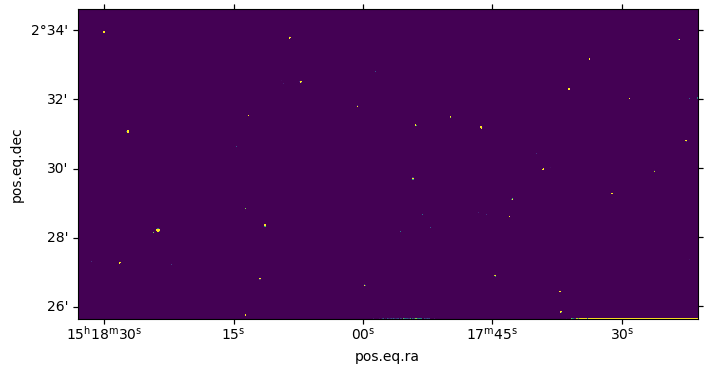

In [85]:
wcs = WCS(single_image[1].header)
zimage = single_image[1].data

fig = plt.figure(figsize=(8,16))
ax = plt.subplot(111, projection=wcs)
lon = ax.coords['ra']
lat = ax.coords['dec']
plt.imshow(zimage,vmin=90,vmax=200)
zimage.shape